# <center>Symbol Synchronization Introductory Demo</center>

This demo includes a graphical interface to specify the module's properties and is meant as an introduction to it's functionality. The **Modulation**, **Samples per symbol**, **Damping factor**, **Normalized loop bandwidth**, **K factor** and **A factor** fields, translate directly to the equivalent module properties.

The **Number of samples** field is the length of the input signal. it populates a variable *n* that can be used in the **Signal** field. Any valid Python expression can be used for the input signal (defined by the *sig* variable). An additional cell has been provided with experimental signals that can be pasted into the Signal field. 

The output shows plots of the (uncorrected) input and (corrected) output signals. It will also report the detected offset.

A new instance should be created (using the **Init** button), whenever new parameters (or a new unrelated input signal) are specified. To clear the ouput, use the Jupyter Notebook's own shortcuts. Refer to the documentation in the Help menu.

In [ ]:
%matplotlib inline

import ipywidgets as widgets
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import sksdr
import utils

ssync = None
output_samples = None

def init(b):
    global ssync
    mod = modulation_widget.value
    sps = sps_widget.value
    damp_factor = damp_factor_widget.value
    norm_loop_bw = norm_loop_bw_widget.value
    K = K_widget.value
    A = A_widget.value
    ssync = sksdr.SymbolSync(mod, sps, damp_factor, norm_loop_bw, K, A)
    with disp:
        print('Initiated with ' + repr(ssync))

def execute(b):
    global ssync, output_samples, disp
    n = np.arange(num_samples_widget.value)
    _locals = {'n': n}
    exec(signal_widget.value, None, _locals)
    sig = _locals['sig']
    fig = plt.figure(figsize=(15,10))
    gs = gridspec.GridSpec(1, 2, figure=fig)
    with disp:
        sksdr.time_plot([sig], [''], [1], 'Input Signal', fig=fig, gs=gs[0, 0])
        out, _, _ = ssync(sig)
        sksdr.time_plot([out], [''], [1], 'Output Signal', fig=fig, gs=gs[0, 1])
        plt.show()
        output_samples = out
        print('Output samples available in variable "output_samples"')

style = dict(utils.description_width_style)
settings_grid = widgets.GridspecLayout(3, 3)
settings_grid[0, 0] = modulation_widget = widgets.Dropdown(description='Modulation:', options=[('BPSK', sksdr.BPSK), ('QPSK', sksdr.QPSK)], value=sksdr.QPSK, continuous_update=False, style=style)
settings_grid[0, 1] = sps_widget = widgets.BoundedIntText(description='Samples per symbol:', value=2, min=1, max=np.iinfo(int).max, continuous_update=False, style=style)
settings_grid[0, 2] = damp_factor_widget = widgets.BoundedFloatText(description='Damping factor:', value=1.0, min=0, max=np.finfo(float).max, continuous_update=False, 
style=style)
settings_grid[1, 0] = norm_loop_bw_widget = widgets.BoundedFloatText(description='Normalized loop bandwidth (Hz):', value=0.01, max=np.finfo(float).max, continuous_update=False, style=style)
settings_grid[1, 1] = K_widget = widgets.BoundedFloatText(description='K factor:', value=1.0, min=0, max=np.finfo(float).max, continuous_update=False, style=style)
settings_grid[1, 2] = A_widget = widgets.BoundedFloatText(description='A factor:', value=1/np.sqrt(2), max=np.finfo(float).max, continuous_update=False, style=style)
settings_grid[2, 0] = num_samples_widget = widgets.BoundedIntText(description='Number of samples (n=):', value=200, min=1, max=np.iinfo(int).max, continuous_update=False, style=style)
settings_grid[2, 1:] = signal_widget = widgets.Textarea(description='Signal (sig=):', value='import numpy as np\nsig = np.exp(1j * 2 * np.pi * n / 12)', continuous_update=False, style=style, layout=widgets.Layout(height='auto', width='auto'))
init_button  = widgets.Button(description='Init', tooltip='Init')
init_button.on_click(init)
execute_button = widgets.Button(description='Execute', tooltip='Execute')
execute_button.on_click(execute)
disp = widgets.Output()
ui = widgets.VBox([
    settings_grid,
    widgets.HBox([init_button, execute_button]),
    disp
])
display(ui)

# QPSK signal with fixed delay impairment and AWGN channel
This demo passes a QPSK modulated signal through a block that introduces a fixed delay, and then through an AWGN channel. The received signal will initially appear in a circle. A symbol synchronizer corrects the received signal and it will become grouped around the constellation points.

DEBUG:sksdr.symbol_sync:SSYNC init: theta=0.004000, d=-5.443286, p_gain=-0.002939, i_gain=-0.000012


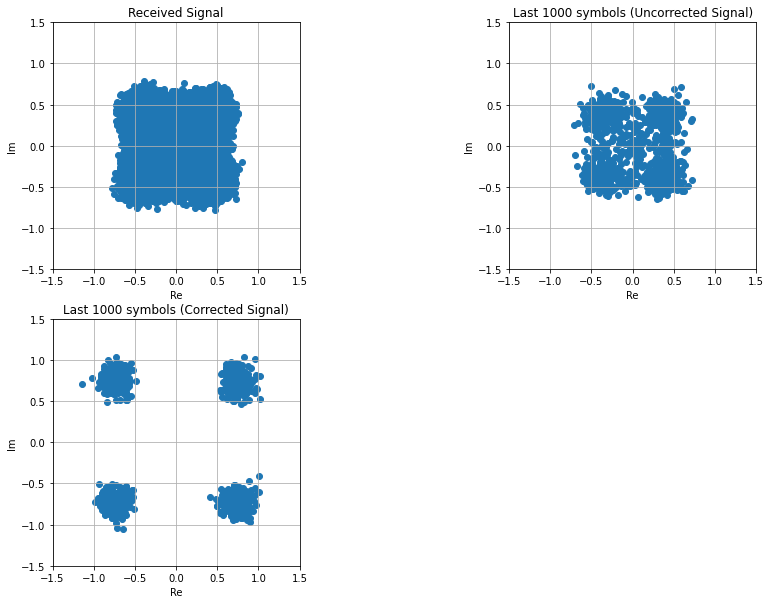

In [1]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import sksdr

# Create a delay offset object
vfd = sksdr.VariableFractionalDelay(max_delay=2)

# Create a symbol timing synchronizer object
ssync = sksdr.SymbolSync(mod=sksdr.QPSK, sps=2, damp_factor=1.0, norm_loop_bw=0.01, K=1.0, A=1/np.sqrt(2))

# Generate random data symbols and apply QPSK modulation
ints = np.random.randint(0, 4, 10000)
bits = sksdr.x2binlist(ints, 2)
psk = sksdr.PSKModulator(sksdr.QPSK, [0, 1, 3, 2], 1.0, np.pi/4)
mod_sig = psk.modulate(bits)

# Interpolate by 4 and filter with RRC tx filter
interp = sksdr.FirInterpolator(4, sksdr.rrc(4, 0.5, 10))
_, tx_sig = interp(mod_sig)

# Apply the delay offset. Then, pass the offset signal through an AWGN channel.
tx_sig_off = vfd(tx_sig, 1)
awgn = sksdr.AWGNChannel(snr=12)
rx_sig = awgn(tx_sig_off)

# Apply the matched filter and decimate by 2
decim = sksdr.FirDecimator(2, sksdr.rrc(4, 0.5, 10))
_, rx_down_sig = decim(rx_sig)

# Correct for the delay offset
sync_sig, _, err_sig = ssync(rx_down_sig)

# Setup figure
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, figure=fig)

# Display the scatter plot of the received signal (set return value to a variable to avoid double plot)
f = sksdr.scatter_plot(rx_sig, 'Received Signal', fig=fig, gs=gs[0, 0])

# Display the last 1000 symbols of corrected signal. The synchronizer has not yet converged so the data is not grouped around the reference constellation points.
f = sksdr.scatter_plot(rx_sig[-1000:], 'Last 1000 symbols (Uncorrected Signal)', fig=fig, gs=gs[0, 1])

# Display the last 1000 symbols of the corrected signal. The data is now aligned with the reference constellation.
f = sksdr.scatter_plot(sync_sig[-1000:], 'Last 1000 symbols (Corrected Signal)', fig=fig, gs=gs[1, 0])

#plt.close('all')

/home/david/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/david/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


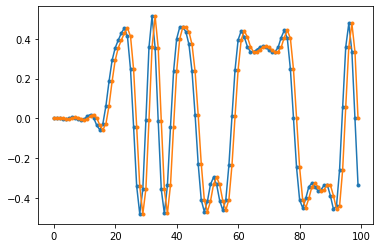

In [4]:
plt.plot(tx_sig[:100], '.-')
plt.plot(tx_sig_off[:100], '.-')